In [1]:
from scipy.signal import savgol_filter
from sklearn.linear_model import RANSACRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xarray.core.formatting import dim_summary

In [2]:
# Load the Raman spectral data from the text file
file_path = "Sample 0.txt"

# Read the data while skipping the header lines
df = pd.read_csv(file_path, sep="\t", comment="#", header=None)

# Keep only the first column pair as wavenumber and intensity
wavenumbers = df.iloc[:, [0,2,4]]
intensities = df.iloc[:, [1,3,5]]

In [3]:
wavenumbers

,0,2,4
0,wn(8/4/2025 3:49:36 PM Index:3),wn(8/4/2025 3:47:54 PM Index:2),wn(8/4/2025 3:46:13 PM Index:1)
1,180.486708504808,180.486708504808,180.486708504808
2,181.467628538334,181.467628538334,181.467628538334
3,182.449291791087,182.449291791087,182.449291791087
4,183.429905306741,183.429905306741,183.429905306741
...,...,...,...
1336,1355.81993629043,1355.81993629043,1355.81993629043
1337,1356.608186908,1356.608186908,1356.608186908
1338,1357.39632837819,1357.39632837819,1357.39632837819
1339,1358.18436072365,1358.18436072365,1358.18436072365


In [4]:
intensities

,1,3,5
0,8/4/2025 3:49:36 PM Index:3,8/4/2025 3:47:54 PM Index:2,8/4/2025 3:46:13 PM Index:1
1,0.444351268066051,0.689969217362016,0.457959214862805
2,0.482111586460149,0.656921923683754,0.486114486317759
3,0.449004541203853,0.663859670218808,0.46658750098449
4,0.469562899526185,0.652870368664354,0.441768257958567
...,...,...,...
1336,0.0956976243127492,0.0221904579963906,0.0436475872340903
1337,0.111030583461004,0.0405412158608649,0.062196500577219
1338,0.133572386537997,0.042606687878015,0.0331854534423533
1339,0.0886414031987004,0.0387935584994571,0.028452142763118


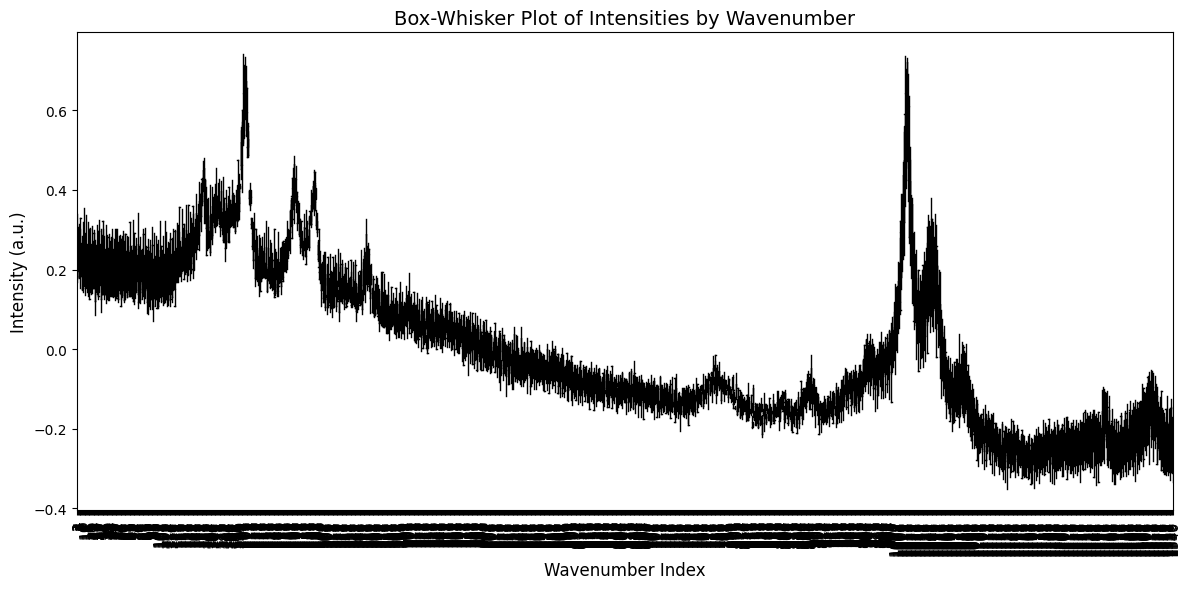

In [5]:
# Plot the consensus spectrum for Sample 0 in black and white
df = intensities.iloc[1:].reset_index(drop=True)
df = df.apply(pd.to_numeric, errors='coerce')
df_centered = df - df.mean(axis=0)

df_t = df_centered.T
# Rename columns to categorical sample labels
df_t.columns = [f"{i+1}" for i in range(df_t.shape[1])]

# Boxplot (each row now shown as a box) to check the agreement across the 3 measurements taken per sample
plt.figure(figsize=(12, 6))
df_t.boxplot(grid=False, color=dict(boxes='black', whiskers='black', medians='black', caps='black'))

plt.xlabel("Wavenumber Index", fontsize=12)
plt.ylabel("Intensity (a.u.)", fontsize=12)
plt.title("Box-Whisker Plot of Intensities by Wavenumber", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("mean_centered_boxplot_s0_Spectra.png", dpi=300, bbox_inches='tight')
plt.show()

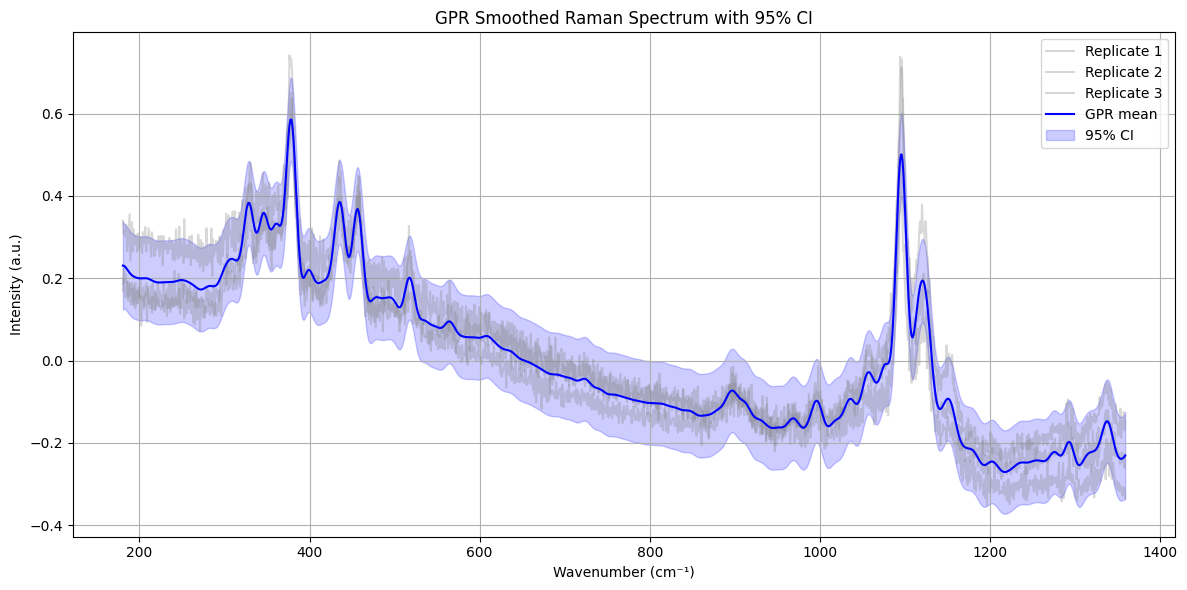

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Prepare data for GPR ---
wavenumber_vals = wavenumbers.iloc[1:, 0].astype(float).values  # e.g., column 0
intensity_vals = df.to_numpy()  # shape: (N_wavenumbers, 3 replicates)

# Flatten into (X, y) pairs
x = np.tile(wavenumber_vals, intensity_vals.shape[1]).reshape(-1, 1)  # (N*3, 1)
y = intensity_vals.T.flatten()  # (N*3,)

# --- Step 2: Define GPR model ---
kernel = RBF(length_scale=100.0) + WhiteKernel(noise_level=0.01)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

# --- Step 3: Fit GPR model ---
gpr.fit(x, y)

# --- Step 4: Predict on fine grid ---
x_pred = np.linspace(wavenumber_vals.min(), wavenumber_vals.max(), 1000).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)

# --- Step 5: Plot results ---
plt.figure(figsize=(12, 6))
for i in range(intensity_vals.shape[1]):
    plt.plot(wavenumber_vals, intensity_vals[:, i], alpha=0.3, label=f"Replicate {i+1}", color='gray')

plt.plot(x_pred.ravel(), y_pred, color="blue", label="GPR mean")
plt.fill_between(x_pred.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                 color="blue", alpha=0.2, label="95% CI")

plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("GPR Smoothed Raman Spectrum with 95% CI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gpr_spectrum_sample0.png", dpi=300)
plt.show()


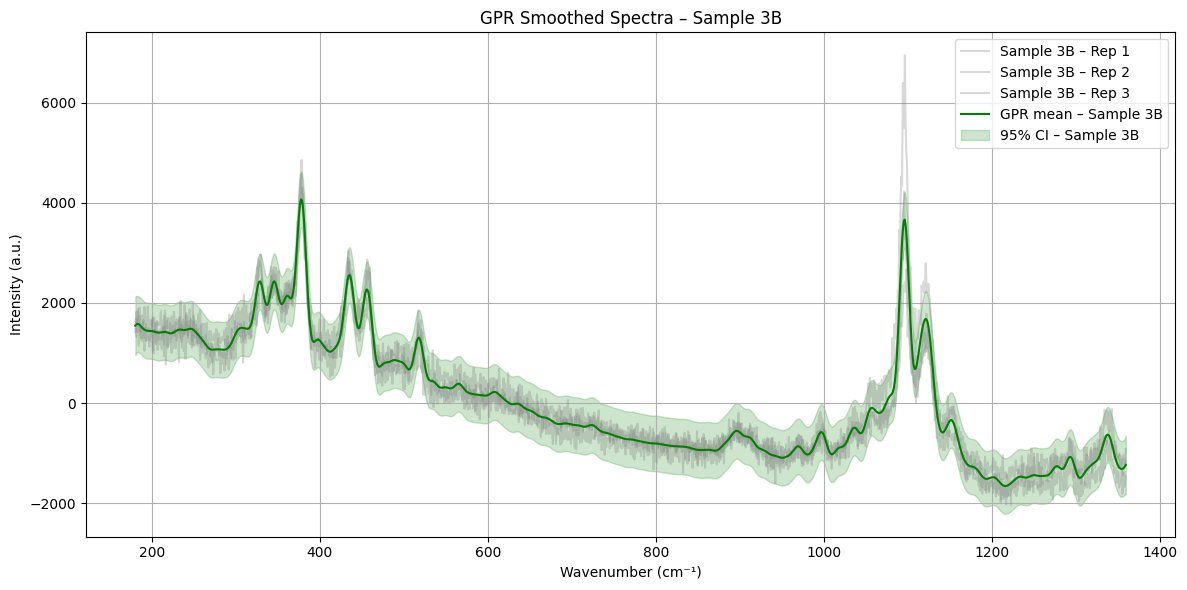

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

def load_sample(file_path, center=True):
    import pandas as pd
    import numpy as np

    # Load file and skip commented lines
    df = pd.read_csv(file_path, sep="\t", comment="#", header=None)

    # Drop the first row (non-numeric headers or metadata)
    df = df.iloc[1:].reset_index(drop=True)

    # Extract wavenumbers and intensities
    wavenumbers = df.iloc[:, [0, 2, 4]]
    intensities = df.iloc[:, [1, 3, 5]]

    # Convert to numeric
    wavenumber_vals = wavenumbers.iloc[:, 0].astype(float).values
    intensity_vals = intensities.apply(pd.to_numeric, errors='coerce')

    # Optional: mean-center across replicates (columns)
    if center:
        intensity_vals = intensity_vals - intensity_vals.mean(axis=0)

    # Convert to NumPy array
    intensity_vals = intensity_vals.to_numpy()

    return wavenumber_vals, intensity_vals

def fit_gpr(wavenumbers, intensities, label, color):
    # Stack replicates for GPR
    x = np.tile(wavenumbers, intensities.shape[1]).reshape(-1, 1)
    y = intensities.T.flatten()

    # Fit GPR
    kernel = RBF(length_scale=100.0, length_scale_bounds=(1e-6, 1e3)) + WhiteKernel(noise_level=0.01)
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gpr.fit(x, y)

    # Predict smooth curve
    x_pred = np.linspace(wavenumbers.min(), wavenumbers.max(), 1000).reshape(-1, 1)
    y_pred, y_std = gpr.predict(x_pred, return_std=True)

    # Plot raw replicate measurements
    for i in range(intensities.shape[1]):
        plt.plot(wavenumbers, intensities[:, i], alpha=0.3, label=f"{label} – Rep {i+1}", color='gray')

    # Plot GPR mean and confidence interval
    plt.plot(x_pred.ravel(), y_pred, color=color, label=f"GPR mean – {label}")
    plt.fill_between(x_pred.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                     color=color, alpha=0.2, label=f"95% CI – {label}")

    return x_pred, y_pred, y_std

# --- Sample 0 ---
wavenumbers_0, intensities_0 = load_sample("Sample 0.txt")

# --- Sample 3B ---
wavenumbers_3b, intensities_3b = load_sample("Sample 3B.txt")

# --- Plot both GPR fits ---
plt.figure(figsize=(12, 6))

# Fit and plot both
#fit_gpr(wavenumbers_0, intensities_0, label="Sample 0", color="blue")
fit_gpr(wavenumbers_3b, intensities_3b, label="Sample 3B", color="green")

plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
#plt.title("GPR Smoothed Spectra – Sample 0 vs Sample 3B")
plt.title("GPR Smoothed Spectra – Sample 3B")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gpr_sample3b.png", dpi=300)
plt.show()

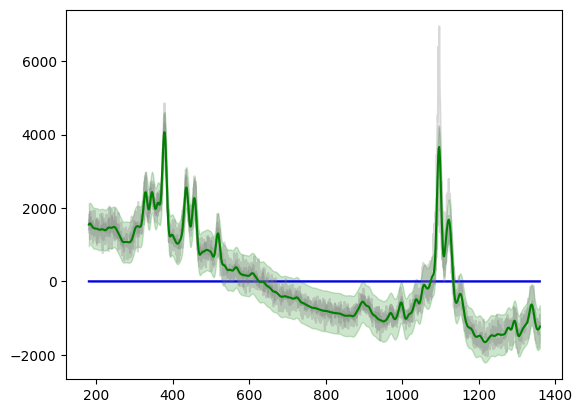

In [75]:
def load_sample(file_path, center=True):
    import pandas as pd
    import numpy as np

    # Load file and skip commented lines
    df = pd.read_csv(file_path, sep="\t", comment="#", header=None)

    # Drop the first row (non-numeric headers or metadata)
    df = df.iloc[1:].reset_index(drop=True)

    # Extract wavenumbers and intensities
    wavenumbers = df.iloc[:, [0, 2, 4]]
    intensities = df.iloc[:, [1, 3, 5]]

    # Convert to numeric
    wavenumber_vals = wavenumbers.iloc[:, 0].astype(float).values
    intensity_vals = intensities.apply(pd.to_numeric, errors='coerce')

    # Optional: mean-center across replicates (columns)
    if center:
        intensity_vals = intensity_vals - intensity_vals.mean(axis=0)

    # Convert to NumPy array
    intensity_vals = intensity_vals.to_numpy()

    return wavenumber_vals, intensity_vals

def fit_gpr(wavenumbers, intensities, label, color):
    # Stack replicates for GPR
    x = np.tile(wavenumbers, intensities.shape[1]).reshape(-1, 1)
    y = intensities.T.flatten()

    # Fit GPR
    kernel = RBF(length_scale=100.0, length_scale_bounds=(1e-6, 1e3)) + WhiteKernel(noise_level=0.01)
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
    gpr.fit(x, y)

    # Predict smooth curve
    x_pred = np.linspace(wavenumbers.min(), wavenumbers.max(), 1000).reshape(-1, 1)
    y_pred, y_std = gpr.predict(x_pred, return_std=True)

    # Plot raw replicate measurements
    for i in range(intensities.shape[1]):
        plt.plot(wavenumbers, intensities[:, i], alpha=0.3, label=f"{label} – Rep {i+1}", color='gray')

    # Plot GPR mean and confidence interval
    plt.plot(x_pred.ravel(), y_pred, color=color, label=f"GPR mean – {label}")
    plt.fill_between(x_pred.ravel(), y_pred - 2*y_std, y_pred + 2*y_std,
                     color=color, alpha=0.2, label=f"95% CI – {label}")

    return x_pred, y_pred, y_std
# --- Sample 0 ---
wavenumbers_0, intensities_0 = load_sample("Sample 0.txt")

# --- Sample 3B ---
wavenumbers_3b, intensities_3b = load_sample("Sample 3B.txt")

# Sample 0
x0, y0, y0_std = fit_gpr(wavenumbers_0, intensities_0, label="Sample 0", color="blue")

# Sample 3B
x3b, y3b, y3b_std = fit_gpr(wavenumbers_3b, intensities_3b, label="Sample 3B", color="green")

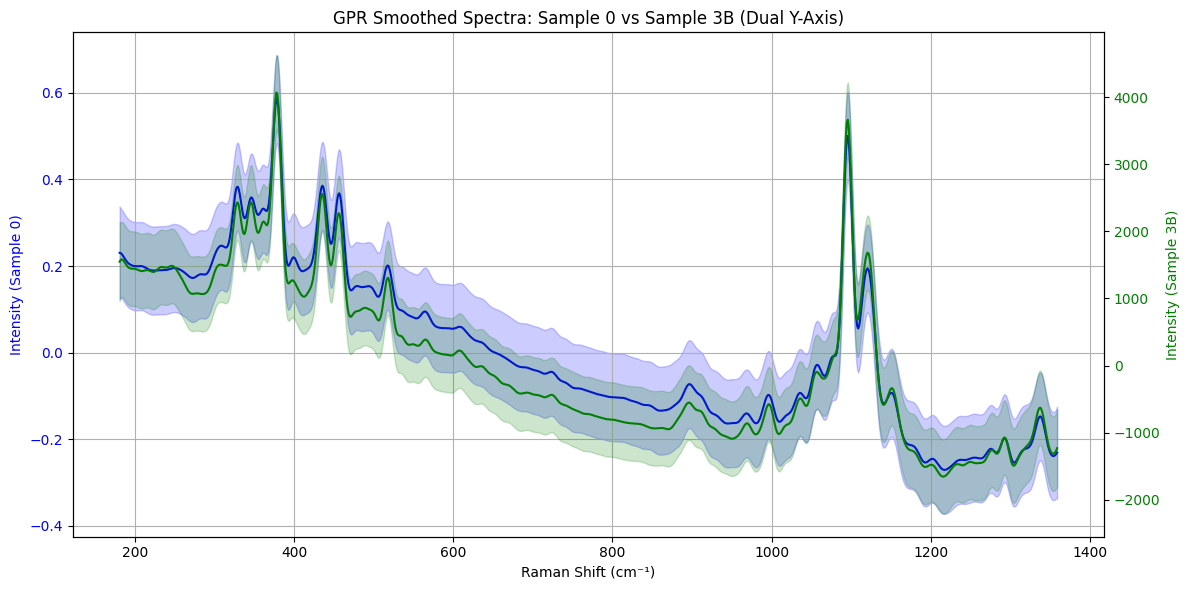

In [77]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis for Sample 0
ax1.plot(x0.ravel(), y0, color="blue", label="Sample 0 – GPR Mean")
ax1.fill_between(x0.ravel(), y0 - 2*y0_std, y0 + 2*y0_std,
                 color="blue", alpha=0.2, label="95% CI – Sample 0")
ax1.set_ylabel("Intensity (Sample 0)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

# Twin y-axis for Sample 3B
ax2 = ax1.twinx()
ax2.plot(x3b.ravel(), y3b, color="green", label="Sample 3B – GPR Mean")
ax2.fill_between(x3b.ravel(), y3b - 2*y3b_std, y3b + 2*y3b_std,
                 color="green", alpha=0.2, label="95% CI – Sample 3B")
ax2.set_ylabel("Intensity (Sample 3B)", color="green")
ax2.tick_params(axis='y', labelcolor='green')

# Shared X-axis
ax1.set_xlabel("Raman Shift (cm⁻¹)")
ax1.set_title("GPR Smoothed Spectra: Sample 0 vs Sample 3B (Dual Y-Axis)")
ax1.grid(True)

plt.tight_layout()
plt.savefig("sample0_vs_3b_dual_y.png", dpi=300)
plt.show()
